In [1]:
import pandas as pd
import datetime
import warnings
import logging
logger = logging.getLogger('my-logger')
logger.propagate = False
logging.disable()

#!pip install geotext
from geotext import GeoText
# we will need the another tool to interact with Geotext
from collections import OrderedDict

import country_converter as coco
import re
import nltk
# !pip install pycountry
import pycountry

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px

1. Introduction
2. Data Description

    2.1 Twitter Data
    
    2.2 Covid Global data
    
    2.3 Limitation and Ethical Concerns
    
3. Data Preperation, Cleaning and Manipulation

    3.1 General Cleaning and Prep
    
    3.2 Adding Country and City for Joining
    
    3.3 Text Cleaning and Sentiment Evaluation
    
4. Exploratory Data Analysis (EDA)

    4.1 Tweeter User Demographics
    
    4.2 Tweets Volumes and Sentiment Score Over time
    
    4.3 (Optional) Sentiment Score Over Time for Other Countries
    
    4.4 (Optional) Relationship Discovery between Daily Sentiment Score and Cumulative Total Cases
    
    4.5 Relationship Discovery between Daily Sentiment Score and Daily New Deaths
    
5. Further Analysis on the U.S.

    5.1 U.S. Tweets Sentiments on the country level and city level
    
    5.2 Word Cloud on the U.S. country and city level
    
    5.3 Correlation Analysis on Twitter var and Covid var for U.S.

## 1. Introduction

As the pandemic has impacted the globe for 3 years and continued to reach repetitive peaks in different regions, epidemics and corresponding preventive measures have become the center of discussion and concerns to modern society. While previously it was much difficult to collect adequate reactions to vaccines across different communities at one place, twitter allows us to access expressed sentiments from a variety of communities.


With that comes various opinions about the vaccine, and many choose to be vocal about their ideas on social media. We wondered whether looking at social media would help us understand what different communities across the world thought of the Vaccine, and whether such opinions are teetered by their socio-political climates and geographical locations.

To do this, we turned to Twitter and scraped tweets containing hastags related to the vaccine. We then took these datapoints and quantified their approval ratings by calcuatinng sentiment score for each text. We then expressed this information in the form of graphs and maps. Currently, we have 5000 datapoints, and over 2000 datapoints with geographical coordinates.

We hope that by reviewing these charts and maps, we can better understand the concerns different communitites have over the vaccine, and what may be contributing factors to this.

The proposed project is to analyze tweets about the Pfizer-BioNTech vaccine in order to understand how sentiment varies by country, over time, and by demographic factors. The project also aims to study the correlation between sentiment and the number of confirmed cases, deaths, and active cases, and to compare the sentiment of tweets about the Pfizer-BioNTech vaccine to the sentiment of tweets about other COVID-19 vaccines. The goal is to gain insights on how people perceive and discuss the Pfizer-BioNTech vaccine on social media in different countries, how it changes over time and how it is influenced by various demographic factors. This information can be useful for researchers, healthcare professionals, and policymakers, to understand public opinion and to develop strategies to improve vaccine uptake.

## 2. Data Description

### 2.1 Twitter Data

Our primary dataset is The Pfizer and BioNTech Vaccine Tweets Dataset posted on Kaggle and created by Gabriel Preda, who is a data scientist in Romania. 

Key features: Select 'user_location' 'text', 'hashtags' to extract useful information we want: locations for geo analysis, and their original tweets about the vaccines for text processing and sentiment analysis
Estimated size: 4.54 MB
Location: https://www.kaggle.com/gpreda/pfizer-vaccine-tweets
Format: CSV file
Access Method: through download or Kaggle API
COLLECTION METHODOLOGY:
Use tweepy to collect tweets about Pfizer & BioNTech (using #PfizerBioNTech hashtag)

### 2.2 COVID-19 Global

Our secondary dataset is the Covid-19 Global Dataset. The creator of the data set is an artificial intelligence engineer from Lebanon. 

Key features: useful columns to include are ‘total_confirmed’, ‘total_deaths’, ‘active_cases’, ‘, country’ to reflect the up-to-date numbers of daily confirmed, death and active cases for 218 countries
Estimated size:20.38 kB (but with multiple versions)
Location: https://www.kaggle.com/josephassaker/covid19-global-dataset?select=worldometer_coronavirus_summary_data.csv
Format: CSV file
Access Method: through download or Kaggle API


### 2.3 Limitation, Potential Bias, Ethical Concerns and handeling

1. Data Privacy: Whe inspecting the Pfizer-BioNTech vaccine tweets dataset, we found that it includes user names and the tweets unique id. To ensure that user's personal information, such as location or identity, is protected in our analysis, we droped the unique id of tweets and encode the usernames into random but unique intergers.

2. Sampling Bias: The Pfizer-BioNTech vaccine tweets dataset may suffer from sampling bias, as Twitter users may not be representative of the broader population. For example, people from the western or developed countries may be more likely to use Twitter and share their opinions about the vaccine. This could potentially skew the results of our analysis.

3. Language and Cultural Bias: The Pfizer-BioNTech vaccine tweets dataset may also suffer from language and cultural bias. We noticed in the collection methodology, section, the author of the vaccine tweets dataset wrote "Use tweepy to collect tweets about Pfizer & BioNTech (using #PfizerBioNTech hashtag)". This means that only the tweets written in english has been collected and the data may not accurately reflect the opinions of non-English speakers or people from other cultural backgrounds.

4. Reporting Bias: The COVID-19 global dataset may suffer from reporting bias, as different countries may have different reporting standards for COVID-19 cases, deaths, and active cases. It is also worth mentioning that some country might not have the ability and resource to collect the statistics. Also, since the covid self-test kits started to be wide avaliable after March 2021, the numbers might not be underestimated. This could potentially skew the results of our analysis and make it difficult to draw conclusions.


## 3. Data Preperation, Cleaning and Manipulation

### 3.1 General Cleaning and Preperation
The code below presented is for data cleaning and preparation, and it involves loading two datasets, cleaning and preparing them for analysis. We start by loading two datasets, "vaccination_tweets.csv" and "worldometer_coronavirus_daily_data.csv", using the Pandas library. Next, we check the shape of the tweet and COVID-19 datasets and the count of missing values for each column using the isna() function. This is important to identify the size of the dataset and the quality of the data.

After that, we subset the tweet dataset to select only relevant columns, such as user_name, user_location, user_created, date, text, hashtags, retweets, and favorites. This helps to remove any irrelevant information from the dataset and improve performance. We also factorize the user_name column to encode it using integers to protect user privacy, and use Pandas' to_datetime() function to convert the date column in each dataset to a datetime object and change the format to date. This helps to standardize the date format across the datasets.

Overall, this code demonstrates some important steps in data cleaning and preparation, including checking for missing values, selecting relevant columns, encoding data to protect privacy, and standardizing the date format.

#### 3.1.1 We loaded two datasets, "vaccination_tweets.csv" and "worldometer_coronavirus_daily_data.csv", using the Pandas library.

In [2]:
# load the datasets:
tweet_df = pd.read_csv("data/vaccination_tweets.csv")
covid_df = pd.read_csv("data/worldometer_coronavirus_daily_data.csv")

#### 3.1.2 We checked the shape of the tweet dataset and the count of missing values for each column, to identify the size of the dataset and the quality of the data.

In [3]:
# check for shape and missing values of the tweeter dataset
print(tweet_df.shape)
print(tweet_df.isna().sum())
tweet_df.sample(5)

(11020, 16)
id                     0
user_name              0
user_location       2270
user_description     679
user_created           0
user_followers         0
user_friends           0
user_favourites        0
user_verified          0
date                   0
text                   0
hashtags            2582
source                 1
retweets               0
favorites              0
is_retweet             0
dtype: int64


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
1766,1343855528196202501,Gulf News Video,"Dubai, United Arab Emirates","Gulf News videos: Content that matters, and yo...",2011-06-05 10:28:26,9654,269,39,False,2020-12-29 09:45:00,#Video: #Dubai residents queue up to receive #...,"['Video', 'Dubai', 'COVID19', 'Vaccination', '...",TweetDeck,0,0,False
5218,1357331690939629569,Felix,NaN,🇨🇦 proud to be Canadian 🇨🇦,2020-02-18 03:56:45,88,195,186,False,2021-02-04 14:14:27,"""New Zealand approves #PfizerBioNtech vaccine ...","['PfizerBioNtech', 'coronavirus']",Twitter for Android,0,0,False
432,1338751685263548418,Simon Hodes ⬅️2m➡️ 😷,"GP Partner, Watford",NHS GP #Chronoptimist LMC Rep #TeamGP💙Trainer ...,2014-07-28 13:32:12,1973,2435,19123,False,2020-12-15 07:44:09,@padsbigsis @GrandPcn @DrMandipThiara @jim_ree...,NaN,Twitter for Android,0,3,False
8424,1398894464266014721,"د.صالح العسيري MD,FRCSC,FACOG,FACS,FICS",NaN,مكتشف وأستاذ جامعي و إستشاري و محكّم دولي،علاج...,2016-08-18 01:29:18,12321,1068,271,False,2021-05-30 06:50:05,"Reassuringly,however,real-world data from the ...",NaN,Twitter Web App,0,0,False
1463,1341268318817140736,"Jyoti Lenka, MD","Tucson, AZ",PulmCrit fellow @UAzPACCS @UAZMedTucson former...,2019-05-19 21:42:34,65,230,358,False,2020-12-22 06:24:21,"The first to decline federal funding, the firs...",NaN,Twitter for iPhone,1,2,False


#### 3.1.3 Similarly, we checked the shape of the COVID-19 dataset and the count of missing values for each column.

In [4]:
# check for shape and missing values of the covid-19 stats dataset
print(covid_df.shape)
print(covid_df.isna().sum())
covid_df.sample(5)

(184787, 7)
date                           0
country                        0
cumulative_total_cases         0
daily_new_cases            10458
active_cases               18040
cumulative_total_deaths     6560
daily_new_deaths           26937
dtype: int64


,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
63956,2022-4-17,Georgia,1653044.0,115.0,2296.0,16792.0,3.0
54104,2022-4-05,Eritrea,9728.0,0.0,2.0,103.0,0.0
130512,2021-12-11,Philippines,2836190.0,186.0,11546.0,50096.0,135.0
18455,2021-4-05,Bhutan,891.0,0.0,20.0,1.0,0.0
135138,2021-2-20,Russia,4151984.0,12953.0,371675.0,82876.0,480.0


#### 3.1.4 We selected only the relevant columns from the tweet dataset, such as user_name, user_location, user_created, date, text, hashtags, retweets, and favorites, to remove any irrelevant information and improve performance. To protect user privacy and prevent the re-identification of users, we factorized the user_name column to encode it using integers.

In [5]:
# subseting the tweeter data
tweet_df = tweet_df[[ 'user_name','user_location', 'user_created', 'date', 'text', 'hashtags', 'retweets', 'favorites']]
# encode user_name using to integers according to ethical concerns 7202 unique usernames detected
tweet_df['user_name'] = tweet_df['user_name'].factorize()[0]

#### 3.1.5 We used Pandas' to_datetime() function to convert the date column in each dataset to a datetime object, and then changed the format to date, to standardize the date format across the datasets.

In [6]:
# change the format
tweet_df['date'] = pd.to_datetime(tweet_df['date'], errors = 'coerce').dt.date
tweet_df['user_created'] = pd.to_datetime(tweet_df['user_created'], errors = 'coerce').dt.date
covid_df['date'] = pd.to_datetime(covid_df['date'], errors = 'coerce').dt.date

### 3.2 Adding Counrty and City for joining.
#### 3.2.1 First, we installed the "geotext" library using the pip command, as it is not included in the standard Python library. We then imported GeoText and the collections module from Python's standard library for geotext to work.

#### 3.2.2 We defined a function called "get_city" that takes a string argument representing the user's location description. The function tries to extract the city name from the location description using the GeoText library. If the function is able to find a city name, it returns the first city name in the list of cities found by GeoText. If it is not able to find a city name, the function returns None.

In [7]:
def get_city(loc_txt):
    try:
        return GeoText(loc_txt).cities[0]
    except:
        pass
    return None

#### 3.2.3 We defined a function called "get_country" that takes a string argument representing the user's location description. The function tries to extract the country name from the location description using the GeoText library. If the function is able to find a country name, it returns the first country name in the list of country mentions found by GeoText. If it is not able to find a country name, the function returns None.

In [8]:
def get_counrty(loc_txt):
    try:
        return list(GeoText(loc_txt).country_mentions.keys())[0]
    except:
        pass
    
    return None
        

#### 3.2.4 We created two new columns in the tweet_df DataFrame called "city" and "country". We used the "apply" method to apply the "get_city" function to the "user_location" column of the DataFrame and store the result in the "city" column. We then used the "apply" method again to apply the "get_country" function to the "user_location" column of the DataFrame and store the result in the "country" column.

In [9]:
tweet_df['city'] = tweet_df['user_location'].apply(get_city)
tweet_df['country'] = tweet_df['user_location'].apply(get_counrty)

#### 3.2.5 We imported pycountry and defined a new function called "fill_country" that takes two arguments: a string representing the user's location description and a string representing the country name. If the country name is not None, the function returns the country name. If the country name is None, the function tries to find the country name in the location description using the pycountry library. The function checks for country names in three formats: full name, ISO 3166 alpha-2 code, and ISO 3166 alpha-3 code. If the function is able to find a country name, it returns the first country name in the list of candidate country names. If it is not able to find a country name, the function returns None.

We are aware that there might be miltple country/city names mentioned in the description. But we decide this a enough for us to start the analysis.

In [10]:
# second we get the country

def fill_country(loc_txt, country):
    if country!=None:
        return country
    candicates = []
    candicates = [country.name for country in pycountry.countries if country.name in str(loc_txt)]
    if candicates:
        return candicates[0]
    candicates = [country.alpha_2 for country in pycountry.countries if country.alpha_2 in str(loc_txt)]
    if candicates:
        return candicates[0]
    candicates = [country.alpha_3 for country in pycountry.countries if country.alpha_3 in str(loc_txt)]
    if candicates:
        return candicates[0]
    return None

tweet_df['country'] = tweet_df[['user_location','country']].apply(lambda x:fill_country(x['user_location'],x['country']),axis=1)

#### 3.2.6 Here we used the "apply" method again to apply the "fill_country" function to the "user_location" and "country" columns of the DataFrame. We used the "lambda" function to pass both columns to the "fill_country" function and store the result in the "country" column. We used the "apply" method again to apply the "convert" method of the country_converter library to the "country" column of the DataFrame. We used the "to_list" method to convert the "country" column to a list and passed it to the "convert" method. We used the "apply" method again to apply a lambda function to the "country" column of the DataFrame that checks for "not found" values and returns None if a "not found" value is found.

In [12]:
# %%time
warnings.filterwarnings('ignore')
# this may take about 5 mins
# !pip install country_converter
# convert country names to standard format
tweet_df['country'] = tweet_df['country'].apply(lambda x: str(x))
tweet_df['country'] = coco.convert(names=tweet_df['country'].to_list(), to='name_short')
tweet_df['country'] = tweet_df['country'].apply(lambda x: None if x=="not found" else x);
covid_df['country'] = coco.convert(names=covid_df['country'].to_list(), to='name_short')
covid_df['country'] = covid_df['country'].apply(lambda x: None if x=="not found" else x);
# there is nothing we can do about the warning raised

Check out the final result:

In [13]:
print(tweet_df.isna().sum())
tweet_df.sample(5)

user_name           0
user_location    2270
user_created        0
date                0
text                0
hashtags         2582
retweets            0
favorites           0
city             6701
country          4417
dtype: int64


,user_name,user_location,user_created,date,text,hashtags,retweets,favorites,city,country
3257,2213,"California, USA",2012-11-26,2021-01-12,Got second dose of the vaccine yesterday and h...,NaN,0,6,None,Saudi Arabia
10197,2318,"Weinheim, Germany",2010-01-14,2021-08-31,#PfizerBiontech have sealed a deal with #Brazi...,"['PfizerBiontech', 'Brazil']",0,1,Weinheim,Germany
465,366,سیارہ زمین,2009-09-12,2020-12-15,@OffGuardian0 By reading #Pfizer Phase-III det...,"['Pfizer', 'vaccine']",1,1,None,None
4741,3194,"Weston-super-Mare, England",2015-05-06,2021-01-27,Hello Twitter. It’s been three weeks! I needed...,NaN,0,11,None,None
6608,4364,NaN,2017-10-13,2021-03-08,All the factual evidence that the vaccines may...,NaN,0,0,None,None


### 3.3 Text Cleaning and sentiment evaluation
Besides the spacial relationship, we are also interested in the content that users posted. To measure users' approval of the COVID-19 vaccine, we will approach with the sentiment score of the texts.

The nltk library we will be using returns measures of postivity, negativity, neutrality, and a compound sentiment score of the text. The higher the compound sentiment score, the greater the approval.

We will need to import the NLTK library and download some dictionaries to run certain methods.

#### 3.3.1 Some standard text cleaning procedures using regular expression

In [14]:
# make all text lowercase
tweet_df['clean_text'] = tweet_df.text.apply(lambda x: x.lower())

#Remove twitter handlers
tweet_df['clean_text'] = tweet_df['clean_text'].apply(lambda x:re.sub('@[^\s]+','',x))

#remove hashtags
tweet_df['clean_text'] = tweet_df['clean_text'].apply(lambda x:re.sub(r'\B#\S+','',x))

# Remove URLS
tweet_df['clean_text'] = tweet_df['clean_text'].apply(lambda x:re.sub(r"http\S+", "", x))

# Remove all the special characters
tweet_df['clean_text'] = tweet_df['clean_text'].apply(lambda x:' '.join(re.findall(r'\w+', x)))

#remove all single characters
tweet_df['clean_text'] = tweet_df['clean_text'].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

# Substituting multiple spaces with single space
tweet_df['clean_text'] = tweet_df['clean_text'].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

# removing short words
tweet_df['clean_text'] = tweet_df['clean_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

#### 3.3.2 We imported the "nltk" library, which is a toolkit for natural language processing. We used the "download" method of the "nltk" library to download three resources: "punkt", "stopwords", and "vader_lexicon". We also imported three functions from the "nltk" library: "word_tokenize", "stopwords", and "SentimentIntensityAnalyzer". We created a new object called "sia" that represents the "SentimentIntensityAnalyzer" function and "porter" that represents the "PorterStemmer" function..

In [15]:
# downlaod some resouces
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
# load the sentiment function
sia = SentimentIntensityAnalyzer()
# load the stemmer function 
porter = nltk.PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\JYM\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### 3.3.3 In this step we removed stop words and words we do not want to include in the analysis.

In [16]:
# romve stop-wards
stop_words = stopwords.words('english')

# tokenization
tokenized_tweet = tweet_df['clean_text'].apply(lambda x: x.split())

# remove stop-words
tokenized_tweet = tokenized_tweet.apply(lambda x: [item for item in x if item not in stop_words])

# similar to stop words, we create a list of words we don't want
unwanted_words = ['covid','vaccine']
tokenized_tweet = tokenized_tweet.apply(lambda x: [w for w in x if w not in unwanted_words])
tokenized_tweet = tokenized_tweet.apply(lambda x: [w for w in x if not(w.find('http')!=-1)])
tokenized_tweet = tokenized_tweet.apply(lambda x: [w for w in x if not(w.find('vac')!=-1)])
tokenized_tweet = tokenized_tweet.apply(lambda x: [w for w in x if not(w.find('covid')!=-1)])

# de-tokenization
detokenized_tweet = []
for i in range(len(tweet_df)):
    t = ' '.join(tokenized_tweet[i])
    detokenized_tweet.append(t)
tweet_df['tweet_words'] = tokenized_tweet 
tweet_df['clean_text'] = detokenized_tweet

In [17]:
tweet_df[['text','tweet_words','clean_text']].sample(5)

,text,tweet_words,clean_text
9842,Ending the American Military Industrial Comple...,"[ending, american, military, industrial, compl...",ending american military industrial complex wi...
8678,First dosage today 👍 #COVID19 #vaccination #Pf...,"[first, dosage, today]",first dosage today
5997,Two doses in a 3-week schedule (94% efficacy) ...,"[doses, week, schedule, efficacy, bnt162b2, re...",doses week schedule efficacy bnt162b2 recently...
2769,Happy vaccination day 🎉🎉🎉🎉🎉 #COVID19 #Pfizer #...,[happy],happy
3870,@BBCFergusWalsh Nada on 1)approval from #Pfize...,"[nada, approval, delay, data, supporting, risk...",nada approval delay data supporting risk mutat...


#### 3.3.4 We apply four lambda functions to the "clean_text" column of the DataFrame that calculate the sentiment score for each tweet using the "compound", "neg", "pos", and "neu" methods of the "SentimentIntensityAnalyzer" function.

In [18]:
# Now we will calculate the sentiment score for each tweet.

tweet_df['compound_sentiment'] = tweet_df['clean_text'].apply(lambda x:sia.polarity_scores(x)['compound'])
tweet_df['neg_sentiment'] = tweet_df['clean_text'].apply(lambda x:sia.polarity_scores(x)['neg'])
tweet_df['pos_sentiment'] = tweet_df['clean_text'].apply(lambda x:sia.polarity_scores(x)['pos'])
tweet_df['neu_sentiment'] = tweet_df['clean_text'].apply(lambda x:sia.polarity_scores(x)['neu'])

In [19]:
tweet_df.sample(5)

,user_name,user_location,user_created,date,text,hashtags,retweets,favorites,city,country,clean_text,tweet_words,compound_sentiment,neg_sentiment,pos_sentiment,neu_sentiment
6785,4481,NaN,2009-05-13,2021-03-11,Pfizer-Biontech's #CoronavirusVaccine offers m...,['CoronavirusVaccine'],4,14,None,None,pfizer biontechoffers protection earlier thoug...,"[pfizer, biontechoffers, protection, earlier, ...",-0.0258,0.155,0.000,0.845
1829,1254,"Birmingham, AL",2018-12-29,2020-12-30,#fomonomo #COVAX #Pfizer #PfizerBioNTech #Pfiz...,"['fomonomo', 'COVAX', 'Pfizer', 'PfizerBioNTec...",0,28,Birmingham,United States,classmate friend gave,"[classmate, friend, gave]",0.4939,0.000,0.615,0.385
9817,3210,NaN,2019-03-07,2021-08-20,Walk-in Vaccination Clinics @PaircUiCha0imh &a...,NaN,13,15,None,None,walk clinics cork city hall open weekend doses,"[walk, clinics, cork, city, hall, open, weeken...",0.0000,0.000,0.000,1.000
9699,6418,BOS,2009-11-26,2021-08-11,First dose #Pfizer #PfizerVaccine #PfizerBiont...,"['Pfizer', 'PfizerVaccine', 'PfizerBiontech']",0,2,None,Bolivia,first dose,"[first, dose]",0.0000,0.000,0.000,1.000
8456,5566,"Paris, France",2019-11-08,2021-05-29,"Many countries, including 🇲🇪, are applying 2-d...",['COVID19'],1,7,Paris,France,many countries including applying dose regimen...,"[many, countries, including, applying, dose, r...",0.0000,0.000,0.000,1.000


#### 3.3.5 In this code, we merged the tweet and COVID-19 datasets using Pandas' "merge" method and specified the columns on which to merge the two datasets as "country" and "date". We then used the merge method as "left", meaning we kept all rows from the left DataFrame ("tweet_df") and added the matching rows from the right DataFrame ("covid_df"). We applied the "pd.to_datetime" method to the "date" and "user_created" columns of the "merged_df" DataFrame. Finally, we used the "isna" method of the "merged_df" DataFrame to count the number of missing values in each column of the DataFrame. The resulting "merged_df" DataFrame contains information on both the tweet sentiment and the COVID-19 cases for each country and date, which will be useful for analyzing the correlation between the sentiment score and the number of confirmed cases, deaths, and active cases.

In [20]:
merged_df = tweet_df.merge(covid_df, on=['country', 'date'], how='left')
merged_df['date'] = pd.to_datetime(merged_df['date'], errors = 'coerce')
merged_df['user_created'] = pd.to_datetime(merged_df['user_created'], errors = 'coerce')
display(merged_df.sample(5))
merged_df.isna().sum()

,user_name,user_location,user_created,date,text,hashtags,retweets,favorites,city,country,...,tweet_words,compound_sentiment,neg_sentiment,pos_sentiment,neu_sentiment,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
7240,3641,Allgäu (Bayern),2011-12-09,2021-03-23,interesting ➡️6 people developed #coronavirus ...,"['coronavirus', 'symptoms', 'PfizerBiontech']",4,7,None,None,...,"[interesting, people, developed, receiving, dose]",0.4019,0.0,0.403,0.597,4046.0,1.0,0.0,86.0,0.0
4720,3179,NaN,2020-04-29,2021-01-28,money or lives? #PfizerBioNTech should make a ...,"['PfizerBioNTech', 'reddit', 'jadorelargent', ...",0,0,None,None,...,"[money, lives, makechoice]",0.0000,0.0,0.000,1.000,3554.0,29.0,248.0,79.0,0.0
6560,4333,"Toronto, Berlin, Istanbul",2017-07-20,2021-03-05,"My beloved grandmother, an immigrant from Turk...",NaN,1,29,Toronto,Canada,...,"[beloved, grandmother, immigrant, turkey, know...",0.5106,0.0,0.268,0.732,881761.0,3370.0,30412.0,21926.0,40.0
7074,4685,"Grand Island, NY",2013-11-07,2021-03-19,Brilliant system at the vaccine site today in ...,NaN,0,1,Grand Island,United States,...,"[brilliant, system, site, today, buffalo, happ...",0.8779,0.0,0.591,0.409,30656585.0,65819.0,2615579.0,562944.0,1202.0
758,423,"Middle of Nowhere, USA",2015-05-17,2020-12-17,@macroliter Excellent thread.\nO/T: opinion on...,NaN,0,1,None,Saudi Arabia,...,"[excellent, threadt, opinion, info, possible, ...",0.5719,0.0,0.316,0.684,360516.0,181.0,3060.0,6091.0,11.0


user_name                     0
user_location              2270
user_created                  0
date                          0
text                          0
hashtags                   2582
retweets                      0
favorites                     0
city                       6701
country                    4417
clean_text                    0
tweet_words                   0
compound_sentiment            0
neg_sentiment                 0
pos_sentiment                 0
neu_sentiment                 0
cumulative_total_cases       26
daily_new_cases              26
active_cases                229
cumulative_total_deaths      35
daily_new_deaths             50
dtype: int64

## 4. Exploratory Data Analysis (EDA)


### 4.1 User Demographics

In [21]:
df = merged_df.copy()
post_covid_df = merged_df[merged_df['user_created']>=pd.Timestamp(datetime.date(2020, 3, 1))].copy()
pre_covid_df = merged_df[merged_df['user_created']<pd.Timestamp(datetime.date(2020, 3, 1))].copy()

<Figure size 1600x600 with 0 Axes>

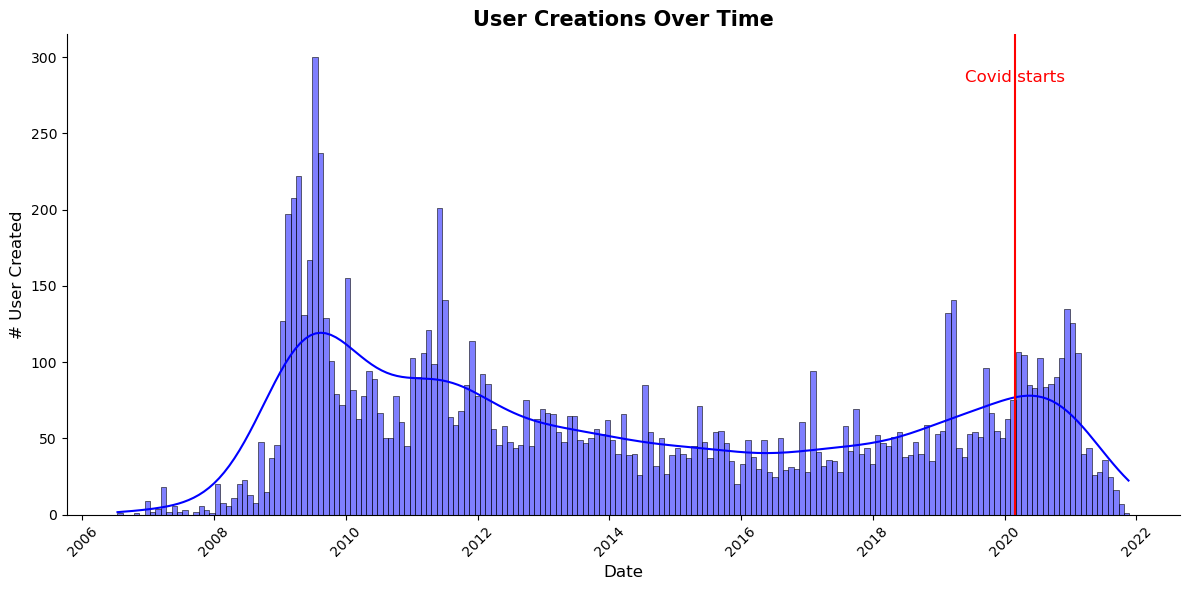

In [22]:
def plot_user_create_over_time(df):
    plt.figure(figsize=(16,6))
    sns.displot(df, x="user_created", kde=True, color='blue',height=6, aspect=2,binwidth=30)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('# User Created', fontsize=12)
    # plt.xlim([datetime.date(2019, 1, 1), datetime.date(2022, 1, 1)])
    plt.axvline(x=datetime.date(2020, 3, 1), color='red')
    plt.text(datetime.date(2020, 3, 1), plt.ylim()[1]*0.9, 'Covid starts', ha='center', color='red', fontsize=12) # Add the annotation
    plt.title('User Creations Over Time', fontsize=15, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
plot_user_create_over_time(df)

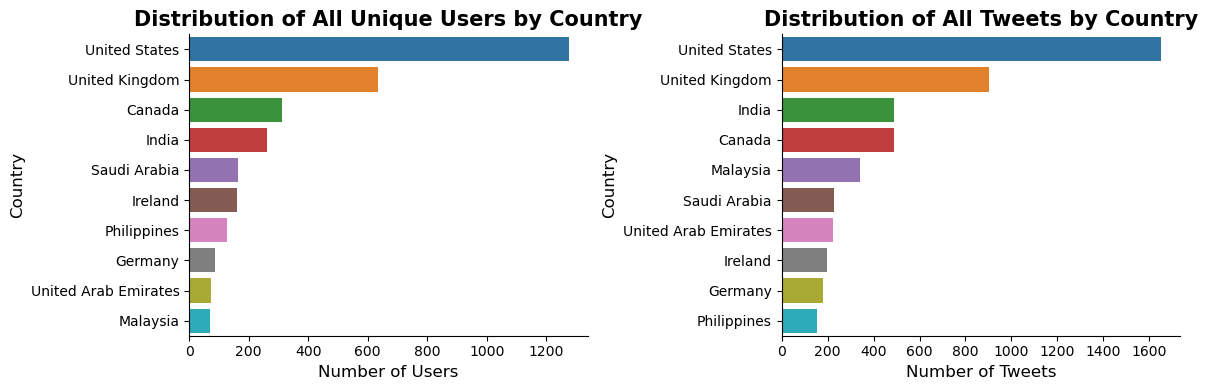

In [23]:
# Create a new figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first countplot in the first subplot
user_country = df[['user_name', 'country']].value_counts().reset_index()
top_10_countries =  user_country['country'].value_counts(sort=False).nlargest(10)
sns.countplot(y=user_country['country'], order=top_10_countries.index, orient='h', ax=axs[0])
axs[0].set_xlabel('Number of Users', fontsize=12)
axs[0].set_ylabel('Country', fontsize=12)
axs[0].set_title("Distribution of All Unique Users by Country", fontsize=15, fontweight='bold')

# Plot the second countplot in the second subplot
top_10_countries =  df['country'].value_counts(sort=False).nlargest(10)
sns.countplot(y=df['country'], order=top_10_countries.index, orient='h', ax=axs[1])
sns.despine() # Remove top and right spines
axs[1].set_xlabel('Number of Tweets', fontsize=12)
axs[1].set_ylabel('Country', fontsize=12)
axs[1].set_title('Distribution of All Tweets by Country', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()


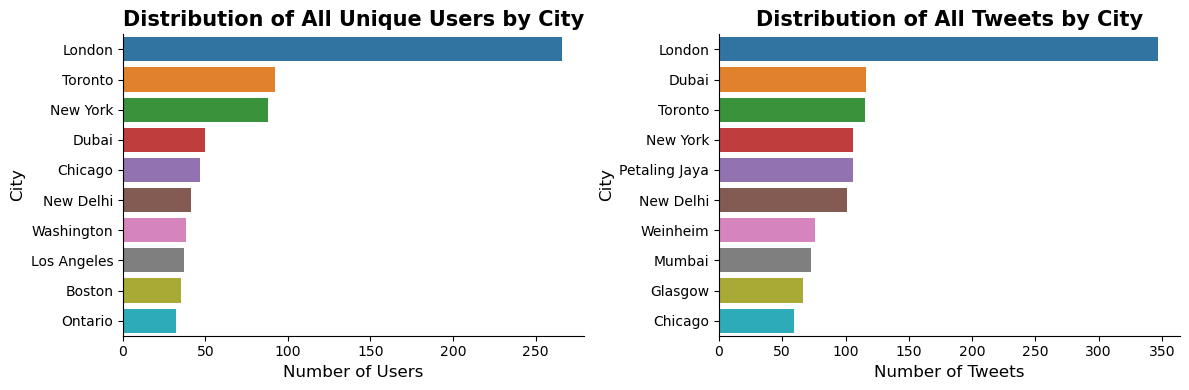

In [24]:
# Create a new figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first countplot in the first subplot
user_country = df[['user_name', 'city']].value_counts().reset_index()
top_10_countries =  user_country['city'].value_counts(sort=False).nlargest(10)
sns.countplot(y=user_country['city'], order=top_10_countries.index, orient='h', ax=axs[0])
axs[0].set_xlabel('Number of Users', fontsize=12)
axs[0].set_ylabel('City', fontsize=12)
axs[0].set_title("Distribution of All Unique Users by City", fontsize=15, fontweight='bold')

# Plot the second countplot in the second subplot
top_10_countries =  df['city'].value_counts(sort=False).nlargest(10)
sns.countplot(y=df['city'], order=top_10_countries.index, orient='h', ax=axs[1])
sns.despine() # Remove top and right spines
axs[1].set_xlabel('Number of Tweets', fontsize=12)
axs[1].set_ylabel('City', fontsize=12)
axs[1].set_title('Distribution of All Tweets by City', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

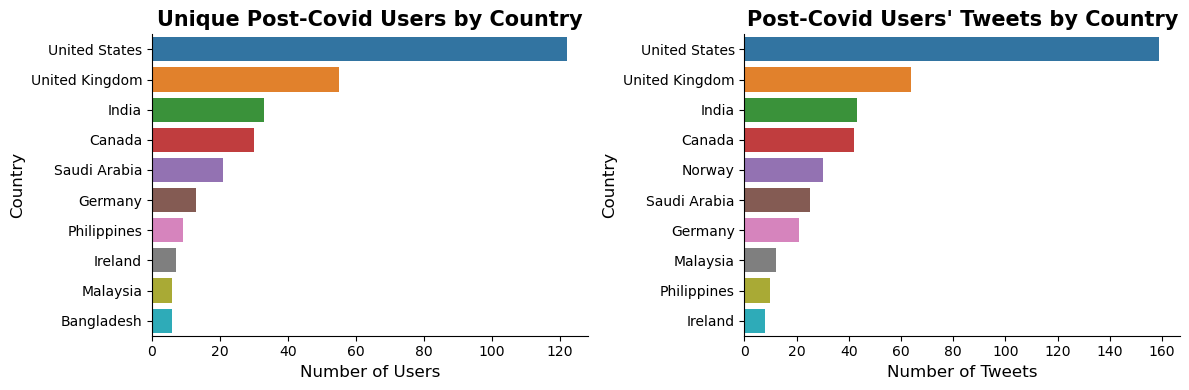

In [25]:
# Create a new figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first countplot in the first subplot
user_country = post_covid_df[['user_name', 'country']].value_counts().reset_index()
top_10_countries =  user_country['country'].value_counts(sort=False).nlargest(10)
sns.countplot(y=user_country['country'], order=top_10_countries.index, orient='h', ax=axs[0])
axs[0].set_xlabel('Number of Users', fontsize=12)
axs[0].set_ylabel('Country', fontsize=12)
axs[0].set_title("Unique Post-Covid Users by Country", fontsize=15, fontweight='bold')

# Plot the second countplot in the second subplot
top_10_countries =  post_covid_df['country'].value_counts(sort=False).nlargest(10)
sns.countplot(y=post_covid_df['country'], order=top_10_countries.index, orient='h', ax=axs[1])
sns.despine() # Remove top and right spines
axs[1].set_xlabel('Number of Tweets', fontsize=12)
axs[1].set_ylabel('Country', fontsize=12)
axs[1].set_title("Post-Covid Users' Tweets by Country", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()


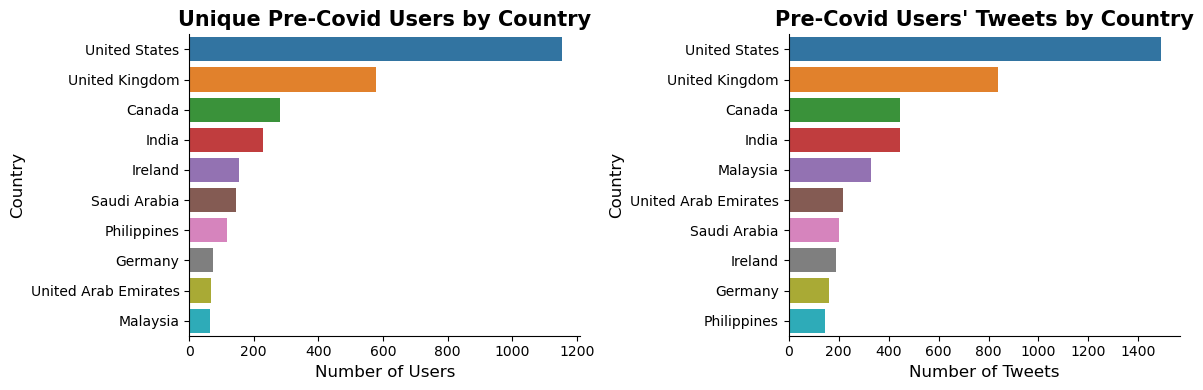

In [26]:
# pre_pandemic
# Convert the date to a pandas-compatible format


# Create a new figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first countplot in the first subplot
user_country = pre_covid_df[['user_name', 'country']].value_counts().reset_index()
top_10_countries =  user_country['country'].value_counts(sort=False).nlargest(10)
sns.countplot(y=user_country['country'], order=top_10_countries.index, orient='h', ax=axs[0])
axs[0].set_xlabel('Number of Users', fontsize=12)
axs[0].set_ylabel('Country', fontsize=12)
axs[0].set_title("Unique Pre-Covid Users by Country", fontsize=15, fontweight='bold')

# Plot the second countplot in the second subplot
top_10_countries =  pre_covid_df['country'].value_counts(sort=False).nlargest(10)
sns.countplot(y=pre_covid_df['country'], order=top_10_countries.index, orient='h', ax=axs[1])
sns.despine() # Remove top and right spines
axs[1].set_xlabel('Number of Tweets', fontsize=12)
axs[1].set_ylabel('Country', fontsize=12)
axs[1].set_title("Pre-Covid Users' Tweets by Country", fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

   ### 4.2 Tweets Volumes and Sentiment Score Over time

<Figure size 1600x2000 with 0 Axes>

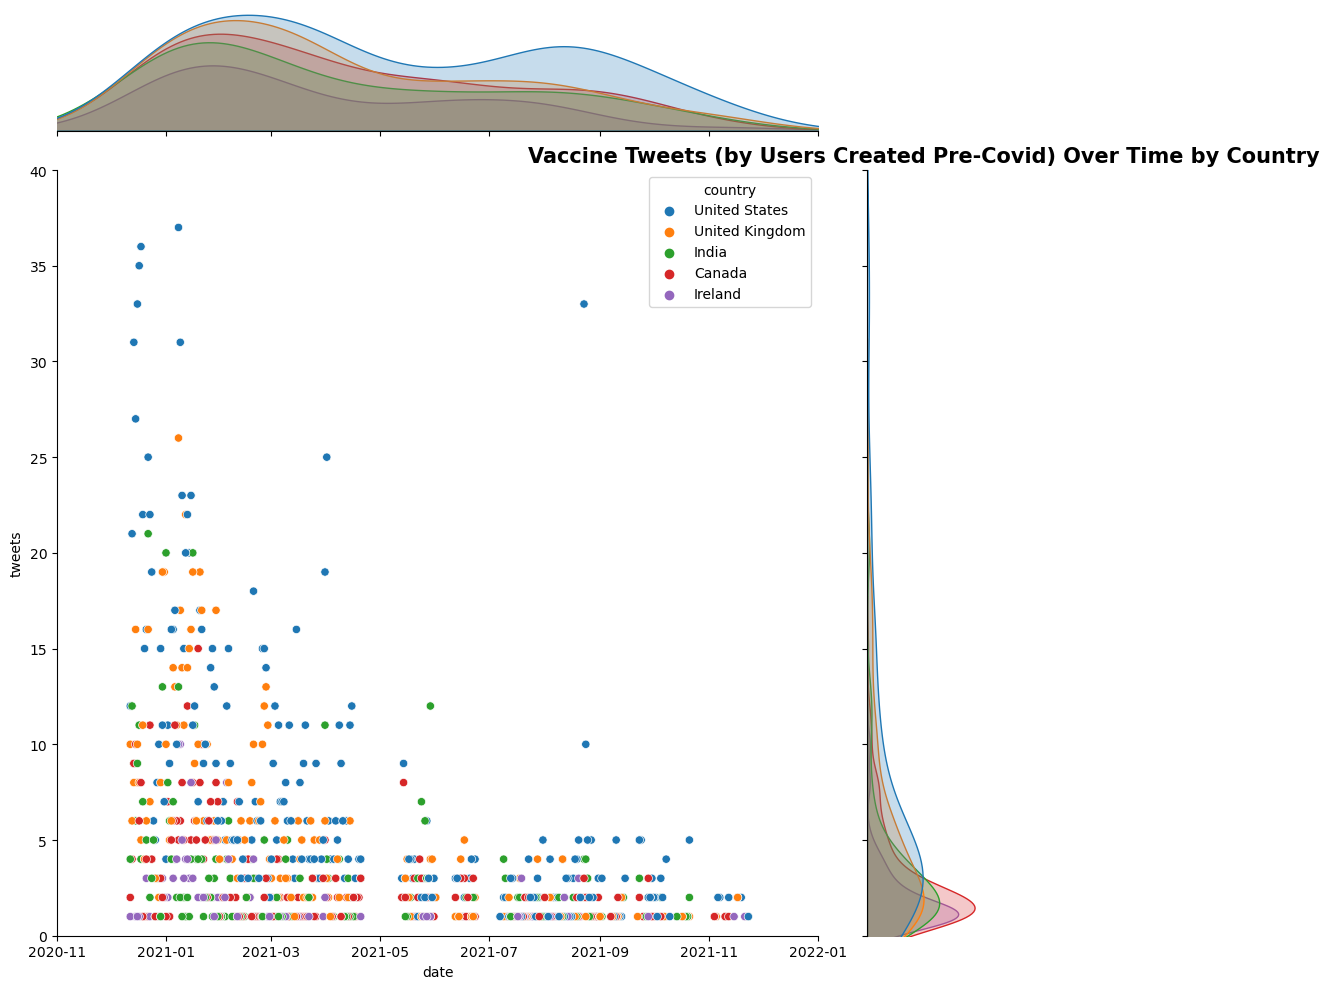

In [27]:
tweet_country = df[['date', 'country']].value_counts().reset_index(name='tweets')
top_5_countries =  user_country['country'].value_counts(sort=False).nlargest(5)
tweet_country = tweet_country[tweet_country['country'].isin(top_5_countries.index)]
# Make the joint plot
plt.figure(figsize=(16, 20))
sns.jointplot(x='date', y='tweets', data=tweet_country, 
              hue='country', height=10, 
              xlim = (datetime.date(2020, 11, 1), datetime.date(2022, 1, 1)), ylim=(0,40))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Vaccine Tweets (by Users Created Pre-Covid) Over Time by Country', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1600x2000 with 0 Axes>

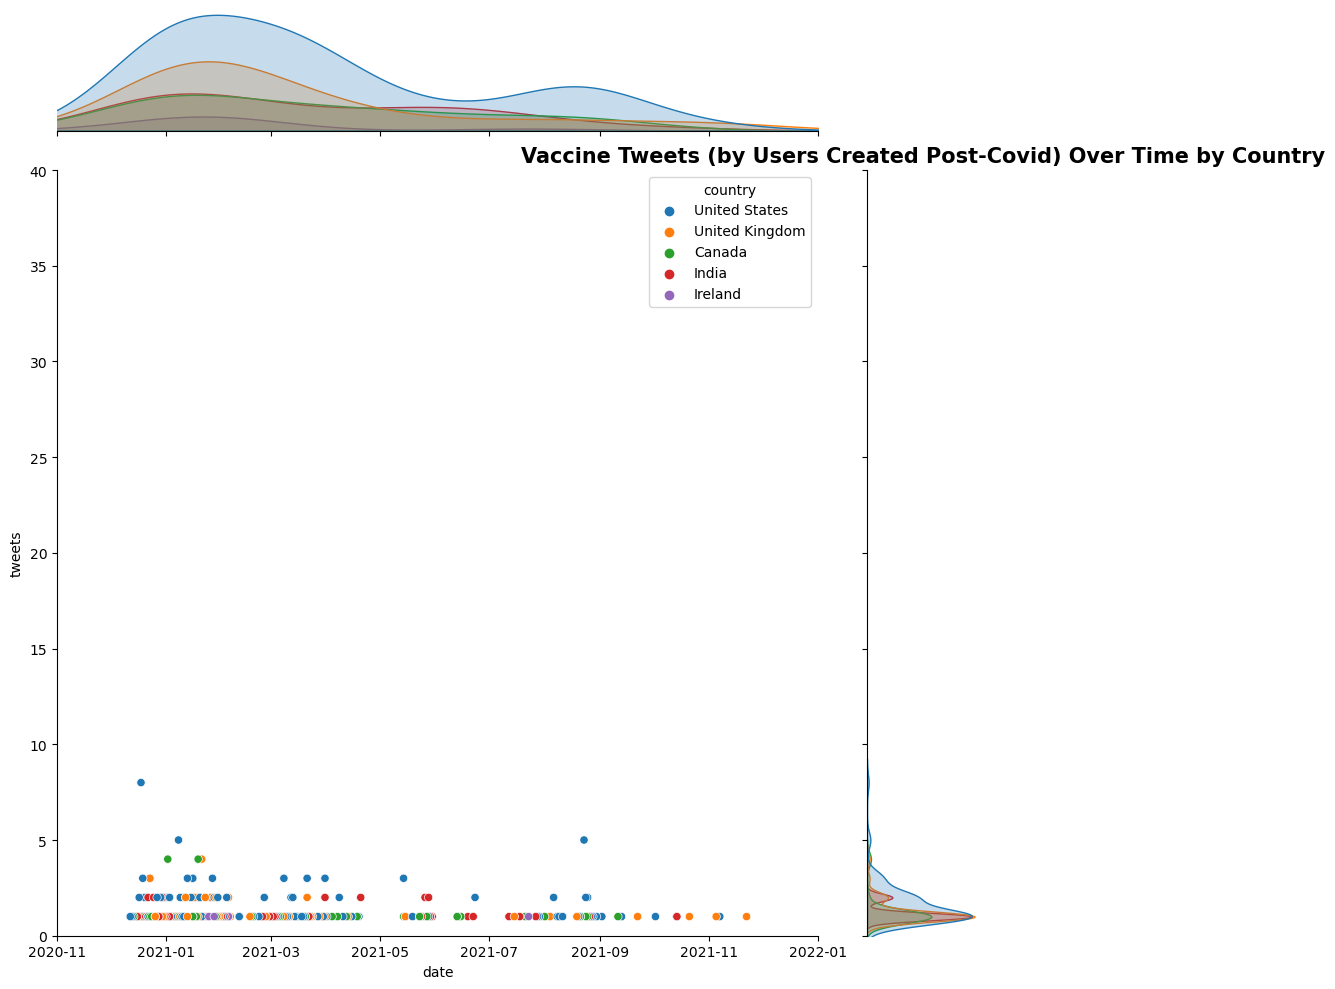

In [28]:
tweet_country = post_covid_df[['date', 'country']].value_counts().reset_index(name='tweets')
top_5_countries =  user_country['country'].value_counts(sort=False).nlargest(5)
tweet_country = tweet_country[tweet_country['country'].isin(top_5_countries.index)]
# Make the joint plot
plt.figure(figsize=(16, 20))
sns.jointplot(x='date', y='tweets', data=tweet_country, 
              hue='country', height=10, 
              xlim = (datetime.date(2020, 11, 1), datetime.date(2022, 1, 1)), ylim=(0,40))
plt.xlabel('Date', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Vaccine Tweets (by Users Created Post-Covid) Over Time by Country', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 1600x2000 with 0 Axes>

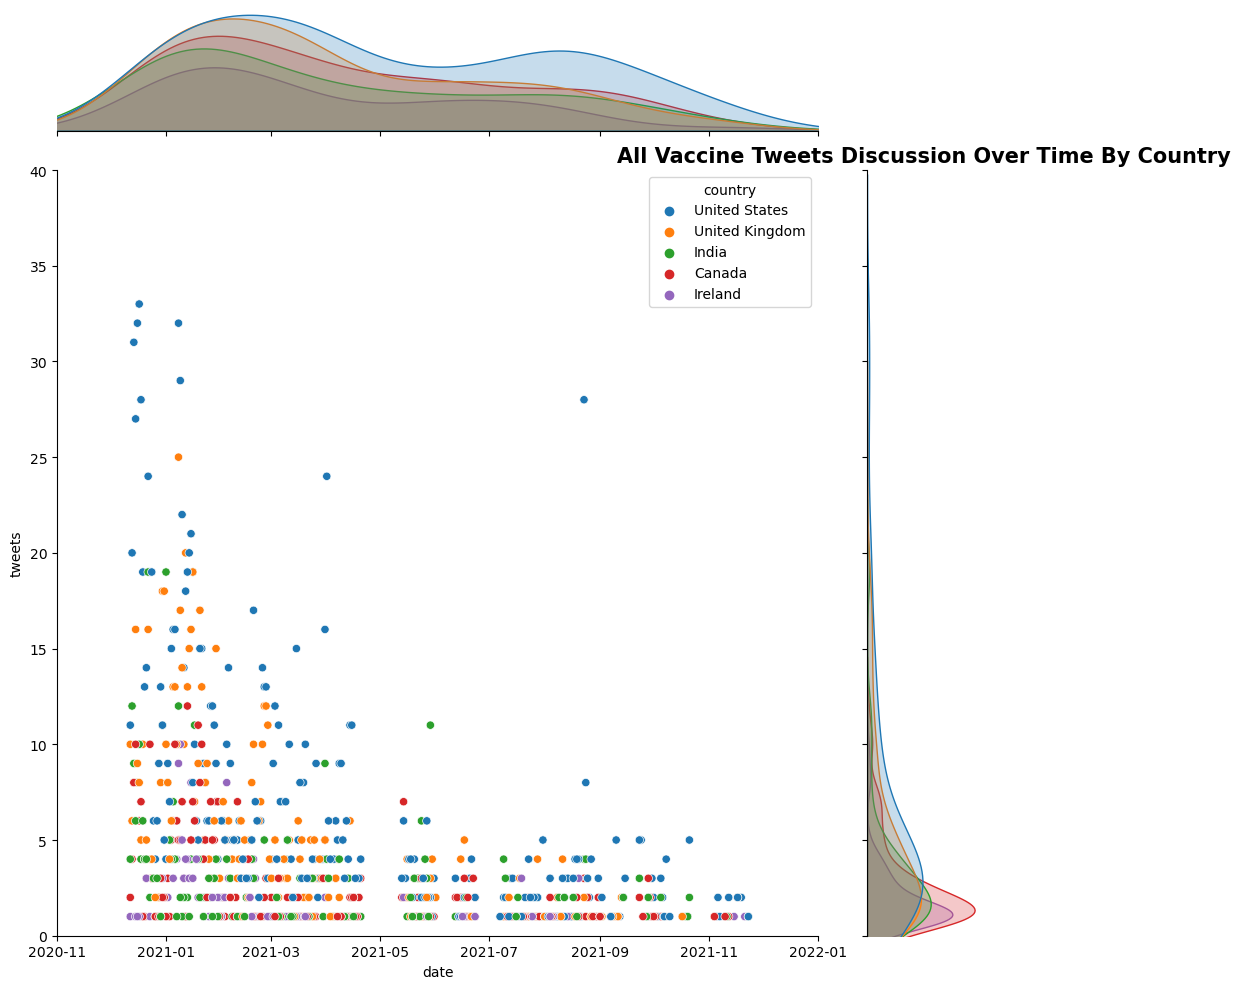

In [29]:
tweet_country = pre_covid_df[['date', 'country']].value_counts().reset_index(name='tweets')
top_5_countries =  user_country['country'].value_counts(sort=False).nlargest(5)
tweet_country = tweet_country[tweet_country['country'].isin(top_5_countries.index)]

# Make the joint plot
plt.figure(figsize=(16, 20))

sns.jointplot(x='date', y='tweets', data=tweet_country, 
              hue='country', height=10, 
              xlim = (datetime.date(2020, 11, 1), datetime.date(2022, 1, 1)), ylim=(0,40))

plt.xlabel('Date', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('All Vaccine Tweets Discussion Over Time By Country', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

In [30]:
# checking sentiments

In [31]:
df = merged_df.copy()
pre_df=df[df['user_created']<pd.Timestamp(datetime.date(2020, 3, 1))]
post_df=df[df['user_created']>pd.Timestamp(datetime.date(2020, 3, 1))]

# extract year and month
df['year_month'] =  df['date'] + pd.offsets.Week(weekday=6)# df['date'].dt.strftime('%Y-%m')
pre_df['year_month'] = pre_df['date'] + pd.offsets.Week(weekday=6)# pre_df['date'].dt.strftime('%Y-%m')
post_df['year_month'] = post_df['date'] + pd.offsets.Week(weekday=6)# post_df['date'].dt.strftime('%Y-%m')

# group by year month
df = df.groupby(["year_month","country"]).mean().reset_index()
pre_df = pre_df.groupby(["year_month","country"]).mean().reset_index()
post_df = post_df.groupby(["year_month","country"]).mean().reset_index()

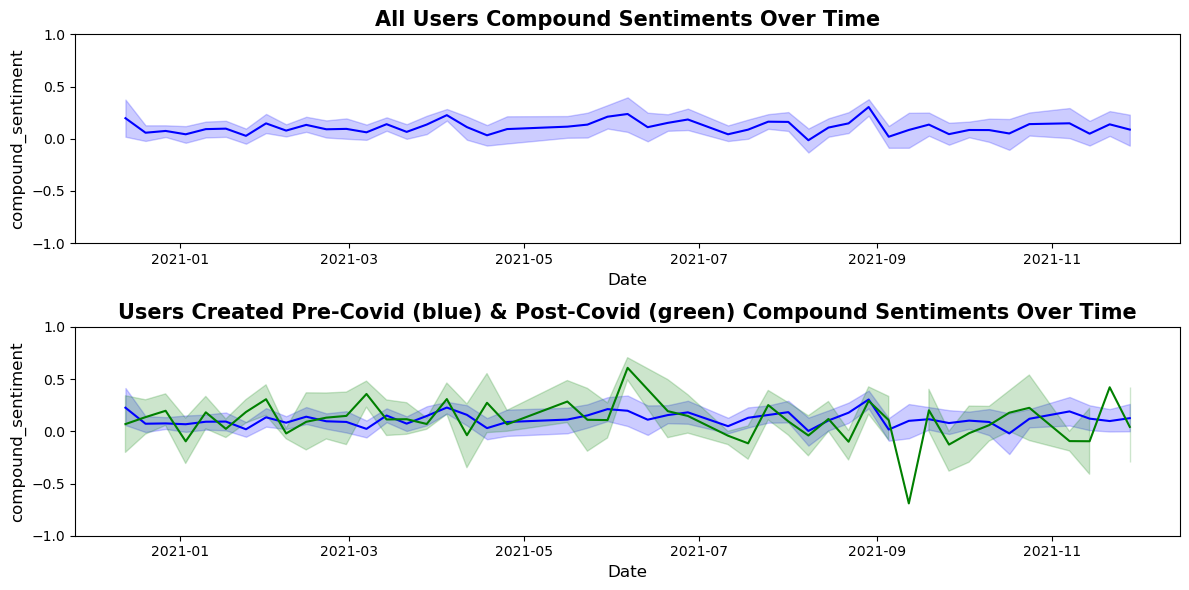

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

sns.lineplot(x='year_month', y='compound_sentiment', data=df, color='blue', ax=axes[0])
axes[0].set_xlabel('Date', fontsize=12)
axes[0].set_ylabel('compound_sentiment', fontsize=12)
axes[0].set_ylim([-1, 1])
axes[0].set_title('All Users Compound Sentiments Over Time', fontsize=15, fontweight='bold')


sns.lineplot(x='year_month', y='compound_sentiment', data=pre_df, color='blue', ax=axes[1])
sns.lineplot(x='year_month', y='compound_sentiment', data=post_df, color='green', ax=axes[1])
axes[1].set_xlabel('Date', fontsize=12)
axes[1].set_ylabel('compound_sentiment', fontsize=12)
axes[1].set_ylim([-1, 1])
axes[1].set_title('Users Created Pre-Covid (blue) & Post-Covid (green) Compound Sentiments Over Time', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()


### 4.3 Sentiment Score Over Time for Other Countries
(Optional, not included in report due to length limit)

In [33]:
df = merged_df.copy()
df['user_type'] = df['user_created'].apply(lambda x: "Pre Pandemic" if x<pd.Timestamp(datetime.date(2020, 3, 1)) else "Post Pandemic")

# extract year and month
df['year_month'] =  df['date'] + pd.offsets.Week(weekday=6)

# get the countruies with most tweets
top_4_countries =  df['country'].value_counts(sort=False).nlargest(4)

# sub set the data
top_4_df = df[df['country'].isin(top_4_countries.index)]

# group by year month
top_4_df = top_4_df.groupby(["year_month","country","user_type"]).mean().reset_index()

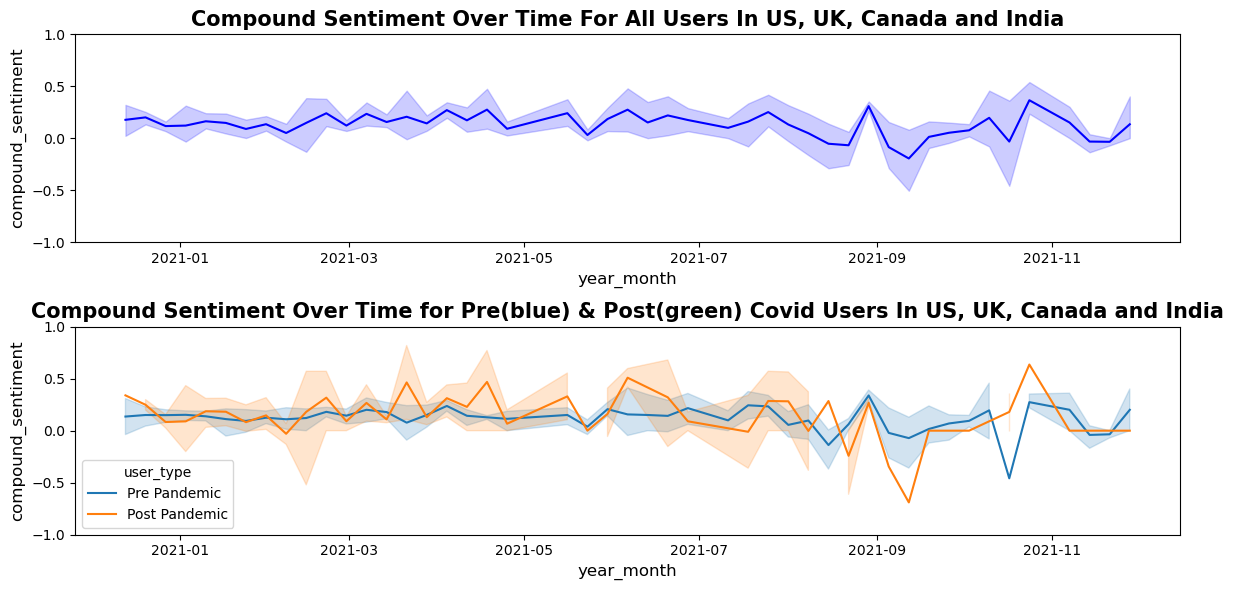

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

sns.lineplot(x='year_month', y='compound_sentiment', data=top_4_df, color='blue', ax=axes[0])
axes[0].set_xlabel('year_month', fontsize=12)
axes[0].set_ylabel('compound_sentiment', fontsize=12)
axes[0].set_ylim([-1, 1])
axes[0].set_title('Compound Sentiment Over Time For All Users In US, UK, Canada and India', fontsize=15, fontweight='bold')

# sns.lineplot(x='year_month', y='compound_sentiment', data=top_4_pre_df, color='blue', ax=axes[1])
# sns.lineplot(x='year_month', y='compound_sentiment', data=top_4_post_df, color='green', ax=axes[1])
sns.lineplot(x='year_month', y='compound_sentiment', data=top_4_df, hue='user_type', ax=axes[1])
axes[1].set_xlabel('year_month', fontsize=12)
axes[1].set_ylabel('compound_sentiment', fontsize=12)
axes[1].set_ylim([-1, 1])
axes[1].set_title('Compound Sentiment Over Time for Pre(blue) & Post(green) Covid Users In US, UK, Canada and India', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

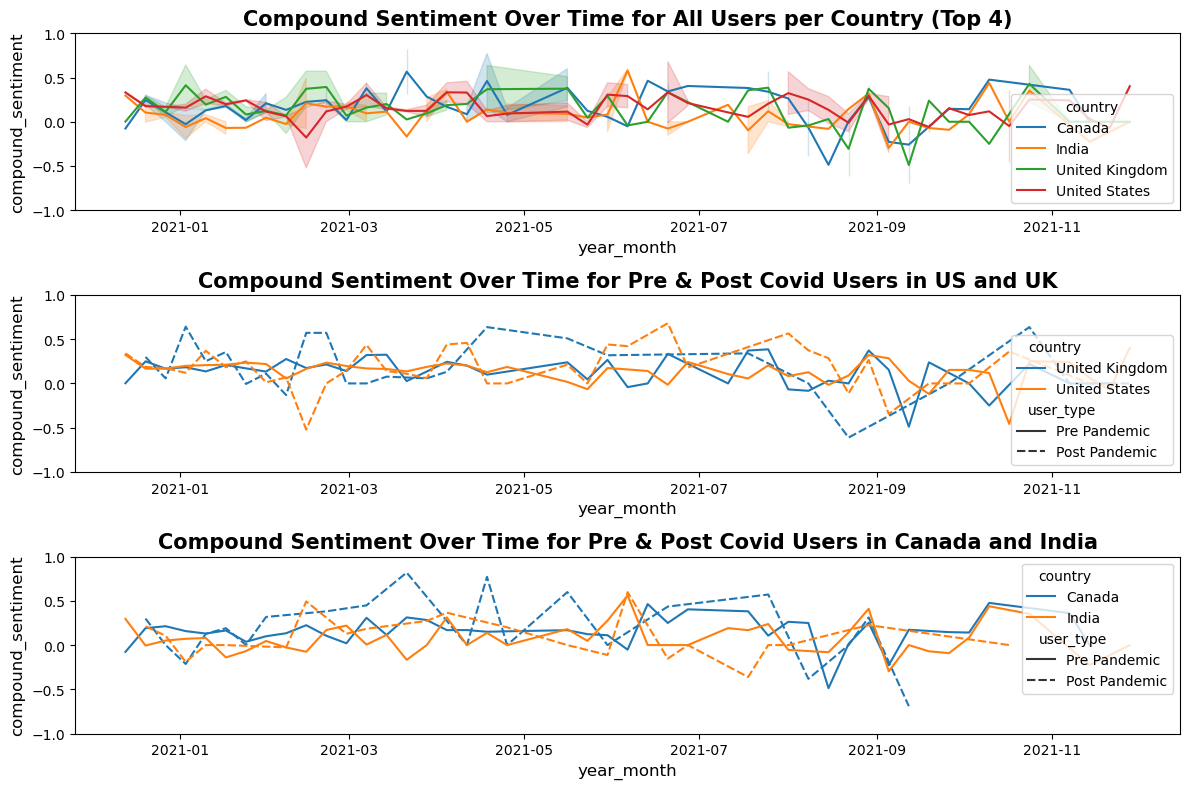

In [35]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

sns.lineplot(x='year_month', y='compound_sentiment', data=top_4_df[top_4_df.country.isin(["United Kingdom","United States","Canada","India"])], hue='country', ax=axes[0])
axes[0].set_xlabel('year_month', fontsize=12)
axes[0].set_ylabel('compound_sentiment', fontsize=12)
axes[0].set_ylim([-1, 1])
axes[0].set_title('Compound Sentiment Over Time for All Users per Country (Top 4)', fontsize=15, fontweight='bold')

sns.lineplot(x='year_month', y='compound_sentiment', data=top_4_df[top_4_df.country.isin(["United Kingdom","United States"])], hue='country', style ="user_type", ax=axes[1])
axes[1].set_xlabel('year_month', fontsize=12)
axes[1].set_ylabel('compound_sentiment', fontsize=12)
axes[1].set_ylim([-1, 1])
axes[1].set_title('Compound Sentiment Over Time for Pre & Post Covid Users in US and UK', fontsize=15, fontweight='bold')

sns.lineplot(x='year_month', y='compound_sentiment', data=top_4_df[top_4_df.country.isin(["Canada","India"])], hue='country', style ="user_type", ax=axes[2])
axes[2].set_xlabel('year_month', fontsize=12)
axes[2].set_ylabel('compound_sentiment', fontsize=12)
axes[2].set_ylim([-1, 1])
axes[2].set_title('Compound Sentiment Over Time for Pre & Post Covid Users in Canada and India', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.4 Relationship Discovery between Daily Sentiment Score and Cumulative Total Cases
(Optional, not included in report due to length limit)

In [1]:
df = merged_df.copy()
df = df[['date','country', 'compound_sentiment','neg_sentiment','pos_sentiment', 'neu_sentiment']].dropna()
df = df.groupby(['country','date']).mean().reset_index()

# df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')

start_date = df['date'].min()
end_date = df['date'].max()


fill_df = []
for name, group in df.groupby('country'):
    group.set_index('date', inplace=True)
    reindexed = group.reindex(pd.date_range(start=start_date, end=end_date, freq='D'))
    reindexed['country'].fillna(name, inplace=True)
    reindexed.fillna(0, inplace=True)
    
    fill_df.append(reindexed.reset_index())

df = pd.concat(fill_df).rename(columns={'index':'date'})
df['date'] = df['date'].astype(str)
pos_df = df.copy()


top_10_countries =  merged_df['country'].value_counts(sort=False).nlargest(10)
df = df[(df['country'].isin(top_10_countries.index))].fillna(0)

# Change in pos_sentiment over time for different countries
fig = px.bar(df,
             y = "country",
             x = 'compound_sentiment',
             animation_frame= 'date',
             range_x = [-1,1],
             color='country'
)
fig.show()


In [2]:
df = covid_df.copy()
top_10_countries =  merged_df['country'].value_counts(sort=False).nlargest(10)
df = df[(df['country'].isin(top_10_countries.index))].fillna(0)

fig = px.bar(df,
             y = "country",
             x = 'cumulative_total_cases',
             animation_frame= 'date',
             range_x = [0,50000000],
             color='country'
)
fig.show()

### 4.5 Relationship Discovery between Daily Sentiment Score and Daily New Deaths

In [3]:
#Plotting interactive choropleth world map to show daily new 
#deaths per country on selected dates/over time
df = covid_df.copy()
fig = px.choropleth(df,
                    locations="country",
                    color="daily_new_deaths",
                    hover_name="country",
                    animation_frame="date",
                    locationmode='country names',
                    color_continuous_scale='Viridis_r',
                    range_color=(0, 1500),
                    height=600,
                    title= "Daily_new_deaths per Day World Map"
                    )
fig.show()

In [4]:
# Change in compound_sentiment over time for different countries
df = pos_df.copy()
fig = px.choropleth(df,
                    locations="country",
                    color="compound_sentiment",
                    hover_name="country",
                    animation_frame="date",
                    locationmode='country names',
                    color_continuous_scale='Viridis_r',
                    range_color=(-1,1),
                    height=600,
                    title= 'Compound Sentiments per Day World Map'
                    )
fig.show()

## 5. Further Analysis Focusing on the U.S. 

### 5.1 U.S. Tweets Sentiments on the country level and city level

In [40]:
# is there a difference between US and other countries?

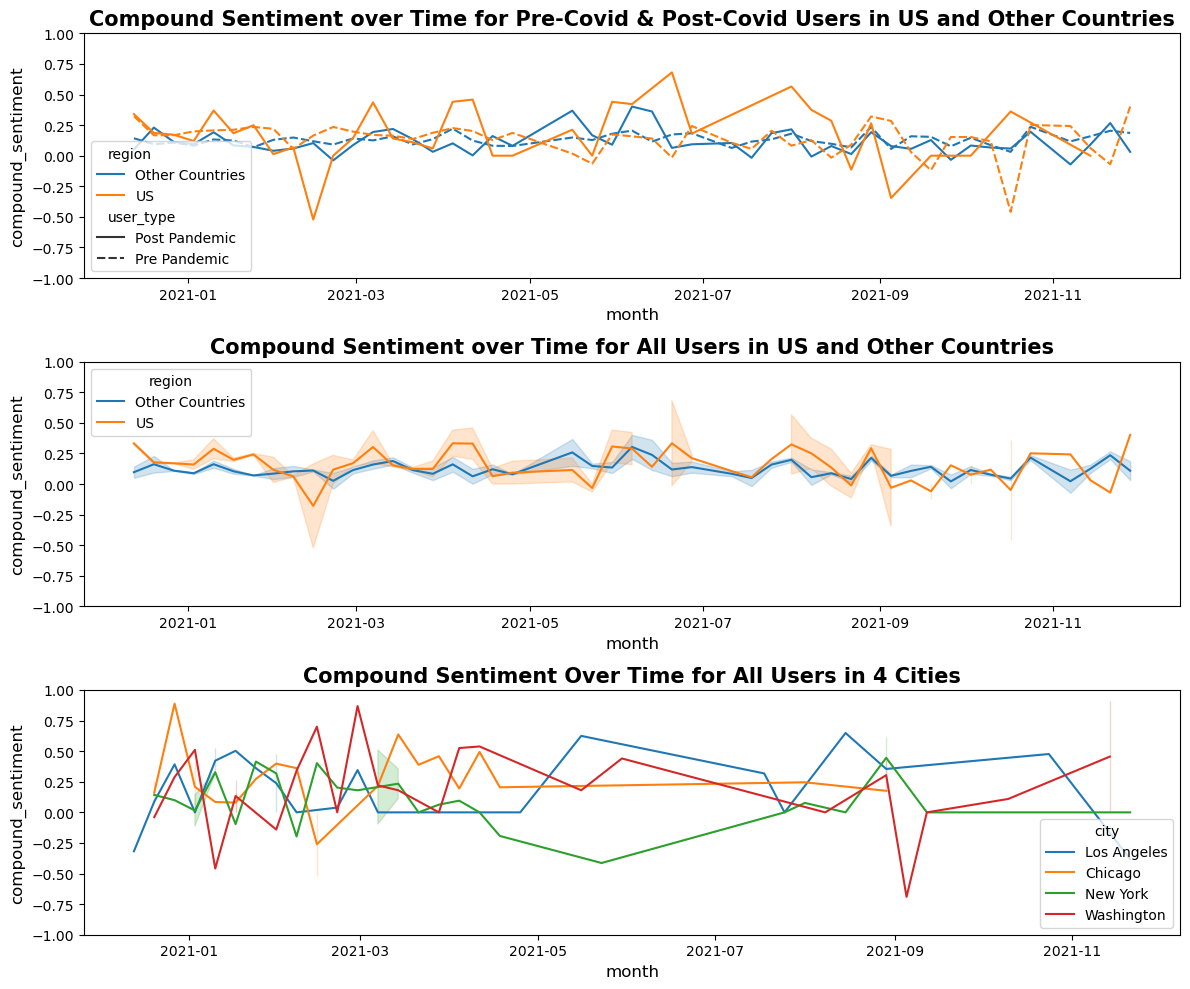

In [41]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

df = merged_df.copy()
df['user_type'] = df['user_created'].apply(lambda x: "Pre Pandemic" if x<pd.Timestamp(datetime.date(2020, 3, 1)) else "Post Pandemic")
df['region'] = df['country'].apply(lambda x: "US" if x=="United States" else "Other Countries")
# extract year and month
df['year_month_week'] =  df['date'] + pd.offsets.Week(weekday=6)
# group by year month
df = df.groupby(["year_month_week","region","user_type"]).mean().reset_index()

sns.lineplot(x='year_month_week', y='compound_sentiment', data=df, hue='region', ax=axes[0], style ="user_type")
axes[0].set_xlabel('month', fontsize=12)
axes[0].set_ylabel('compound_sentiment', fontsize=12)
axes[0].set_ylim([-1, 1])
axes[0].set_title('Compound Sentiment over Time for Pre-Covid & Post-Covid Users in US and Other Countries', fontsize=15, fontweight='bold')

sns.lineplot(x='year_month_week', y='compound_sentiment', data=df, hue='region', ax=axes[1])
axes[1].set_xlabel('month', fontsize=12)
axes[1].set_ylabel('compound_sentiment', fontsize=12)
axes[1].set_ylim([-1, 1])
axes[1].set_title('Compound Sentiment over Time for All Users in US and Other Countries', fontsize=15, fontweight='bold')


df = merged_df.copy()
df['user_type'] = df['user_created'].apply(lambda x: "Pre Pandemic" if x<pd.Timestamp(datetime.date(2020, 3, 1)) else "Post Pandemic")
df['region'] = df['country'].apply(lambda x: "US" if x=="United States" else "Other Countries")
# extract year and month
df['year_month_week'] =  df['date'] + pd.offsets.Week(weekday=6)
# group by year month
df = df.groupby(["year_month_week","city","user_type"]).mean().reset_index()

sns.lineplot(x='year_month_week', y='compound_sentiment', data=df[df.city.isin(['New York', 'Los Angeles',"Chicago","Washington"])], hue='city', ax=axes[2])
axes[2].set_xlabel('month', fontsize=12)
axes[2].set_ylabel('compound_sentiment', fontsize=12)
axes[2].set_ylim([-1, 1])
axes[2].set_title('Compound Sentiment Over Time for All Users in 4 Cities', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

### 5.2 Word Cloud on the U.S. country and city level

#### What are people talking about covid vaccines when they talk about it?

Few interesting Time Points:

U.S. country level:
* Mid-Feb (02-10-2021 - 02-20-2021) 
* Early Sep (09-1-2021 - 09-10-2021) 
* Mid Oct (10-10-2021 - 10-25-2021)

U.S. city level:
* NYC April to August
* Chicago mid December 2020
* Chicago Feb
* Chicago Mid Feb (02-10-2021 - 02-20-2021)

In [42]:

def showWordCloud(df):
    # now put every word from every tweet into a single variable
    all_text = ' '.join(df['clean_text'])
    # create the word cloud
    wordcloud = WordCloud(width=1200, 
                      height=800,
                      background_color="white").generate(all_text)

    # Display the WordCloud                    
    plt.figure(figsize=(8,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

   #### 5.2.1 US Mid-Feb (02-10-2021 - 02-20-2021) Post-Covid Users

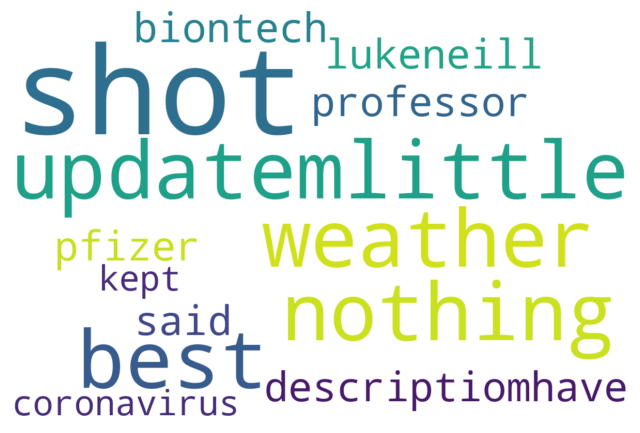

In [43]:
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 2, 20)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2021, 2, 10)))
                     &(merged_df['user_created']>pd.Timestamp(datetime.date(2020, 3, 1)))
                     &(merged_df['country'].isin(["United States"]))]
showWordCloud(df_temp)

#### 5.2.2 US Early Sep (09-1-2021 - 09-10-2021) Post-Covid Users

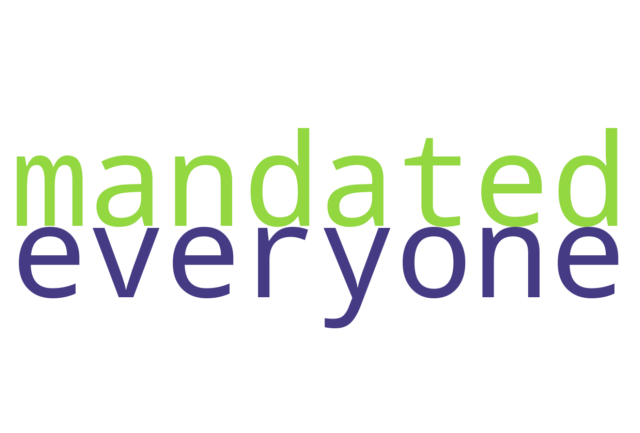

In [44]:
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 9, 10)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2021, 9, 1)))
                     &(merged_df['user_created']>pd.Timestamp(datetime.date(2020, 3, 1)))
                     &(merged_df['country'].isin(["United States"]))]
showWordCloud(df_temp)

#### 5.2.3 US Mid Oct (10-10-2021 - 10-25-2021) Pre-Covid Users

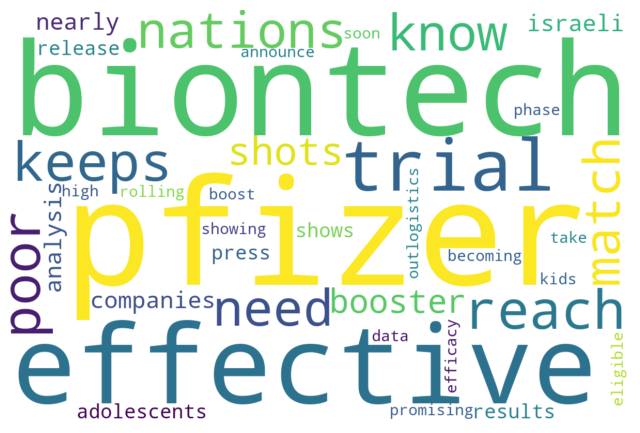

In [45]:
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 10, 25)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2021, 10, 10)))
                     &(merged_df['user_created']<pd.Timestamp(datetime.date(2020, 3, 1)))
                     &(merged_df['country'].isin(["United States"]))]
showWordCloud(df_temp)

#### 5.2.4 US Mid Oct (10-10-2021 - 10-25-2021) Post-Covid Users

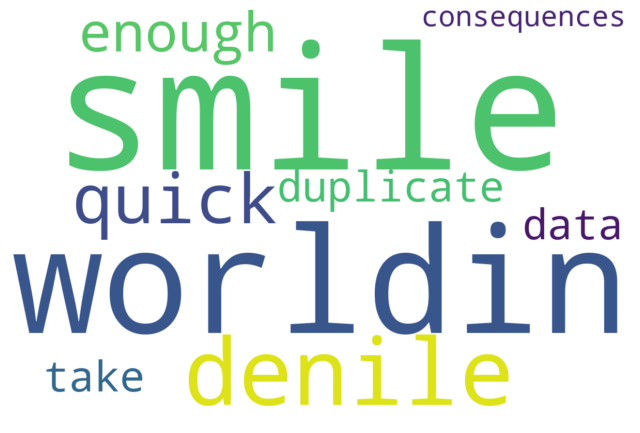

In [46]:
# us mid oct post users
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 10, 25)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2021, 10, 10)))
                     &(merged_df['user_created']>pd.Timestamp(datetime.date(2020, 3, 1)))
#                      &(merged_df['compound_sentiment']<0.25)
                     &(merged_df['country'].isin(["United States"]))]
showWordCloud(df_temp)

#### 5.2.5 NYC April to August All Users

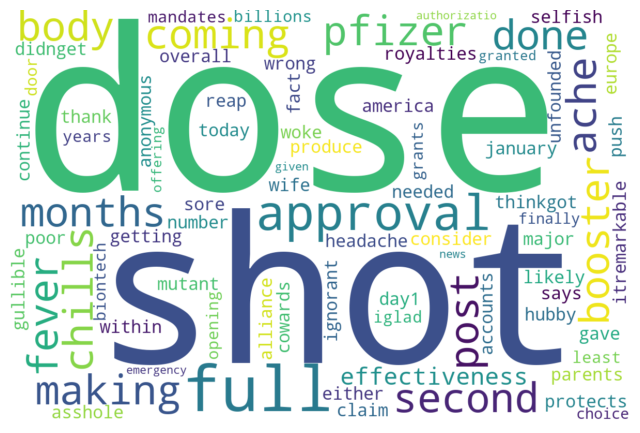

In [47]:
# NYC 4-8
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 8, 31)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2021, 4, 1)))
                     &(merged_df['city'].isin(["New York"]))]
showWordCloud(df_temp)

#### 5.2.6 Chicago Mid December 2020 All Users

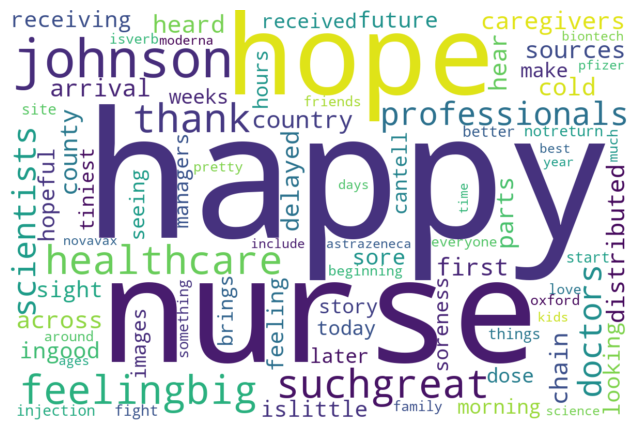

In [48]:
# Chicago 2020-12
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 1, 1)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2020, 12, 10)))
                     &(merged_df['city'].isin(["Chicago"]))]
showWordCloud(df_temp)

#### 5.2.7 Chicago Febuary All Users

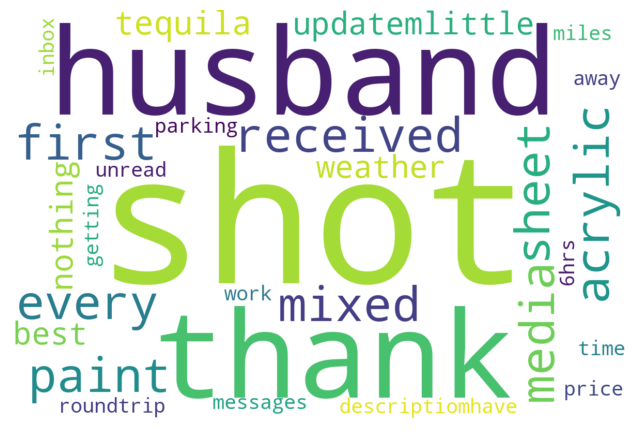

In [49]:
# Chicago 2021- feb 
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 3, 1)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2021, 2, 1)))
                     &(merged_df['city'].isin(["Chicago"]))]
showWordCloud(df_temp)

#### 5.2.8 Chicago Mid Feb (02-10-2021 - 02-20-2021)

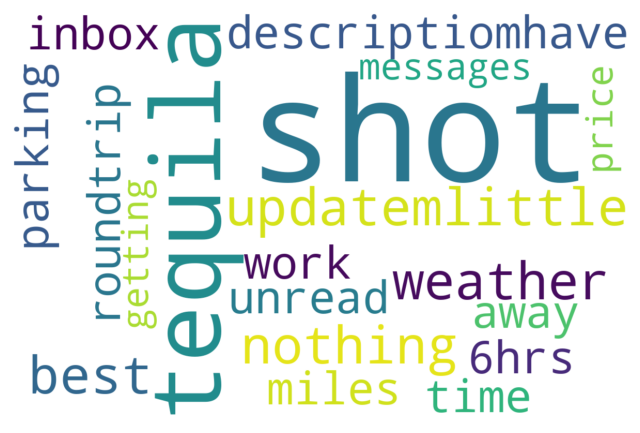

In [50]:
# Chicago 2021-2-mid
df_temp = merged_df [(merged_df["date"]<pd.Timestamp(datetime.date(2021, 2, 20)))
                     &(merged_df["date"]>=pd.Timestamp(datetime.date(2021, 2, 10)))
                     &(merged_df['city'].isin(["Chicago"]))]
showWordCloud(df_temp)

In [51]:
# people are complaining baout side affects and also shaming people who choose not to get vaccines.

## 5.3 Correlation Analysis on Twitter var and Covid var for U.S.

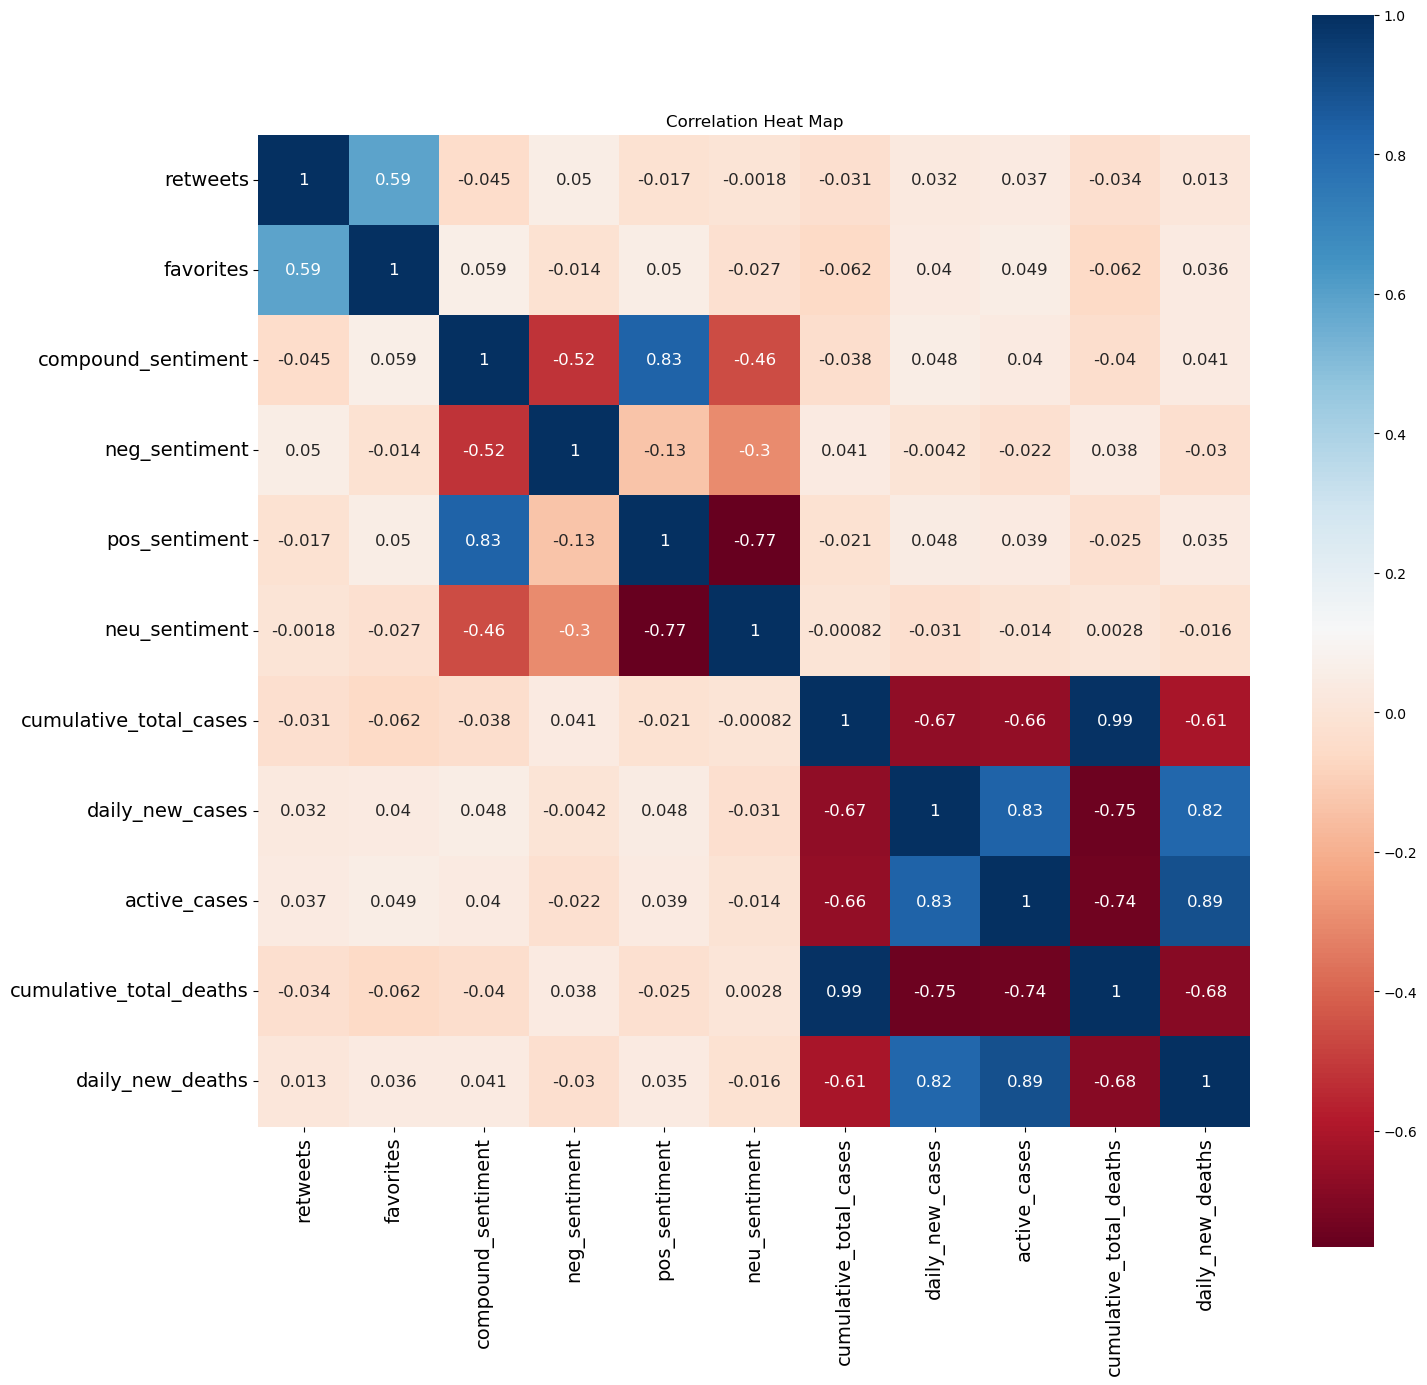

In [52]:
df = merged_df.copy()
df = df[df['country']== 'United States'][['retweets','favorites', 'compound_sentiment','neg_sentiment',  'pos_sentiment',  'neu_sentiment',  'cumulative_total_cases',
        'daily_new_cases',  'active_cases',  'cumulative_total_deaths','daily_new_deaths']].fillna(0)
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(16, 16),facecolor='w')

sns.heatmap(df.corr(),annot=True, vmax=1, square=True, cmap="RdBu", fmt='.2g',annot_kws={"fontsize":12})
plt.title('Correlation Heat Map')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

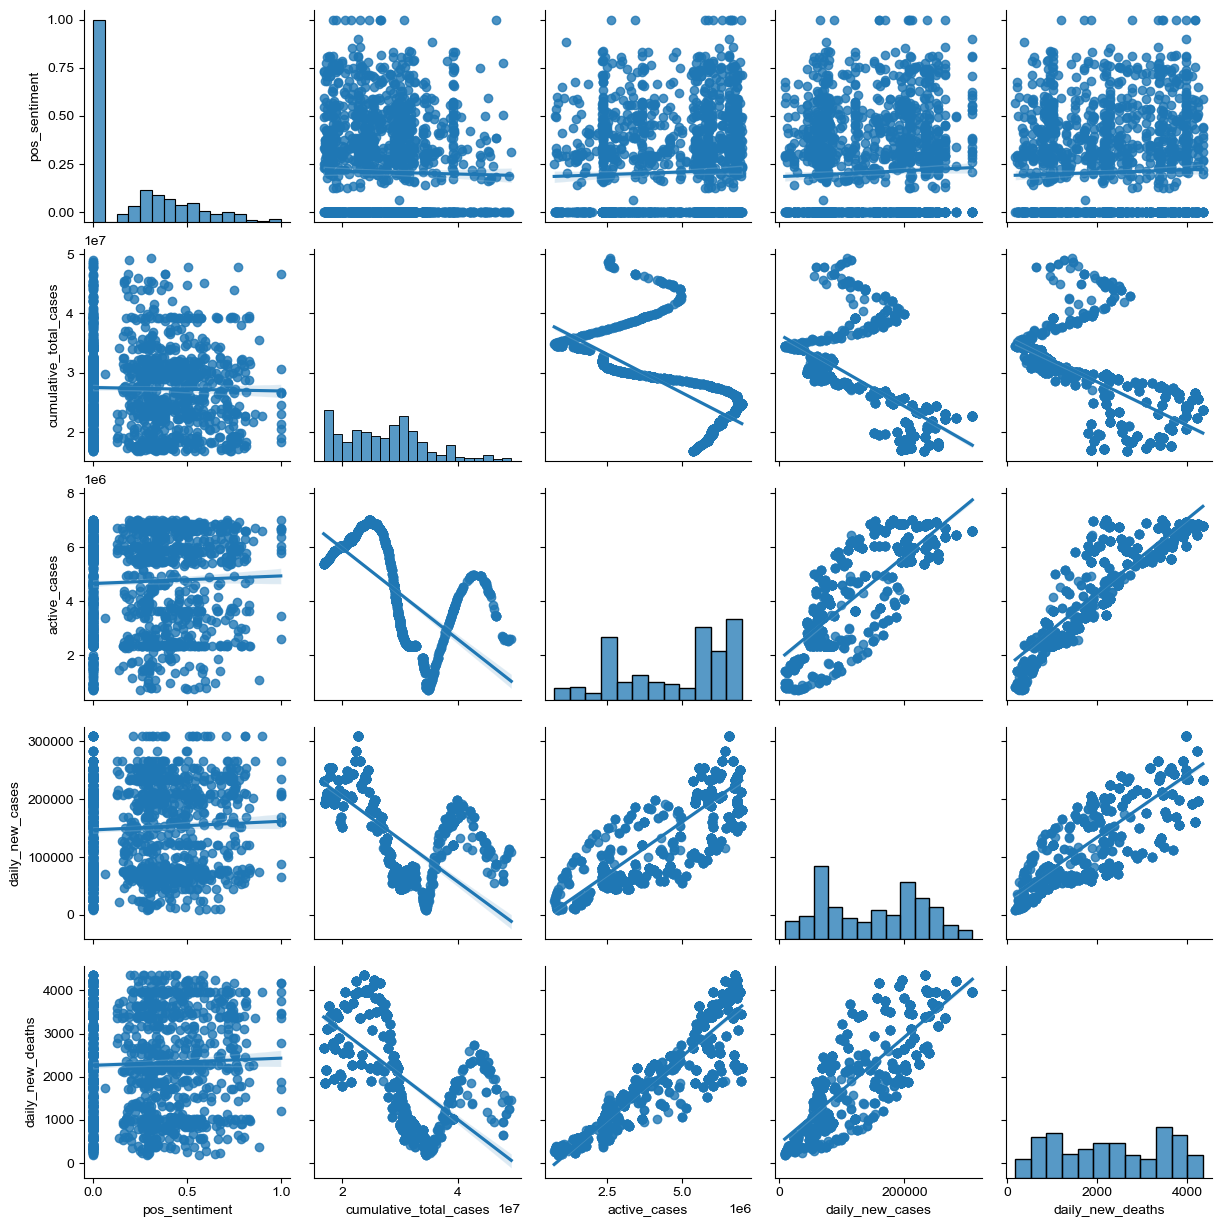

In [53]:
cols = ['pos_sentiment', 'cumulative_total_cases', 'active_cases', 'daily_new_cases','daily_new_deaths']
sns.pairplot(df[cols],kind='reg')
sns.set(font_scale= 1.2)